In [216]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [63]:
data = pd.read_csv('data/cleaned_data.csv', 
                   parse_dates=['Fully Paid','Approved']).drop(['Unnamed: 0'],axis=1)

In [64]:
# Select only the past 5 years of data to make sure the data is relevant
data = data[data['Fully Paid'] > '2014-05-15']

In [225]:
data['Proposed Occupancy'].value_counts()

R-3      4362
R-2      3385
U        1375
Other     396
B         284
M         173
S-2       172
E          95
Name: Proposed Occupancy, dtype: int64

### 1. Regression analysis

* Data has both continuous and categorical variable. In order to conduct regression analysis to predict the duration of the building permit, we need to convert the categorical variables into numeric dummies.
* Then we need to combine the relevant columns of the data into a single dataframe, on whic we will perform the regression analysis.

In [227]:
# convert the categorical variables into numeric dummies
df_cat = pd.get_dummies(data[['Borough', 'Building Type', 'Efiling Filed',
        'Applicant Professional Title', 'Professional Cert','Proposed Occupancy']], 
                        drop_first = True)

# by specifying "drop_first=True" we ensure that there is no correlation among the dummies.
# Basically, for n categories we will have n-1 dummies.

df_cat = df_cat.rename(columns={'Building Type_OTHERS':'Building Type',
                                'Efiling Filed_Y':'Efiled',
                               'Applicant Professional Title_RA':'Pro Title',
                               'Professional Cert_Y':'Pro Certified'})
df_cat.head()

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,Proposed Occupancy_E,Proposed Occupancy_M,Proposed Occupancy_Other,Proposed Occupancy_R-2,Proposed Occupancy_R-3,Proposed Occupancy_S-2,Proposed Occupancy_U
0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0
3,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1
4,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0
5,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0
6,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0


In [228]:
# Create a combined dataframe with the columns to use for prediction
col_to_use = ['Total Est. Fee','Proposed Dwelling Units','Proposed Zoning Sqft', 
              'Proposed No. Of Stories','Total_Construction_Floor_Area',
              'Proposed Height','Duration']

df_combined = pd.merge(df_cat, data[col_to_use], 
    left_index=True, right_index=True)
df_combined.head(2)

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,Proposed Occupancy_E,Proposed Occupancy_M,...,Proposed Occupancy_R-3,Proposed Occupancy_S-2,Proposed Occupancy_U,Total Est. Fee,Proposed Dwelling Units,Proposed Zoning Sqft,Proposed No. Of Stories,Total_Construction_Floor_Area,Proposed Height,Duration
0,0,0,1,0,0,1,1,0,0,0,...,1,0,0,243.0,2.0,2700,2,4050,28,158.0
3,0,0,1,0,0,1,1,1,0,0,...,0,0,1,100.0,NaN,300,1,300,12,87.0


#### Examining the distribution of the target variable (duration)

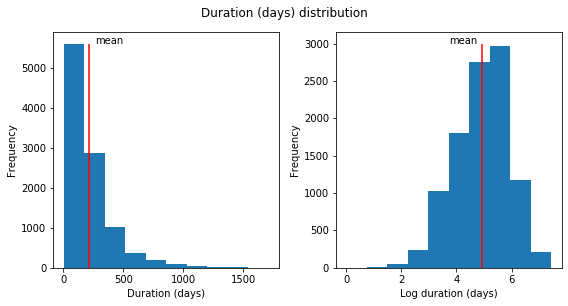

In [229]:
# Plot the target variable distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
data[['Duration']].plot.hist(ax=ax1, legend=False)
ax1.vlines(data[['Duration']].mean(), 0, 5600, color='red')
ax1.annotate('mean', (data[['Duration']].mean()+50, 5600))
ax1.set_xlabel('Duration (days)')
np.log(data[['Duration']]).plot.hist(ax=ax2, legend=False);
ax2.vlines(np.log(data[['Duration']]).mean(), 0, 3000, color='red')
ax2.annotate('mean', (np.log(data[['Duration']]).mean()-1.2, 3000))
ax2.set_xlabel('Log duration (days)')
plt.suptitle('Duration (days) distribution', y=1.05)
plt.tight_layout()

In [230]:
print("The log mean duration is e^{:.2f} = {:.1f} days".format(
    (np.log(data[['Duration']]).mean()[0]), np.exp(np.log(data[['Duration']]).mean()[0])))
print("The mean duration is {:.1f} days".format(data[['Duration']].mean()[0]))

The log mean duration is e^4.93 = 137.8 days
The mean duration is 210.5 days


* We can see that the duration is not normally distributed, it is skewed to right. Log presentation of the duration shows a more normal distribution. 
* Hence, we will use the log of the duration for the regression analysis.

#### 1.1 Linear Regression - OLS (StatsModel)

In [70]:
import statsmodels.api as sm

In [231]:
# Create the X and y for the regression
X = df_combined.drop('Duration', axis=1)
y = np.log(df_combined['Duration'].values.reshape(-1,1)) # taking the log values for y

In [232]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     211.3
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:10:55   Log-Likelihood:                -9912.3
No. Observations:                8513   AIC:                         1.987e+04
Df Residuals:                    8491   BIC:                         2.002e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [233]:
print("The adjusted R square of the OLS model is: {:.2f}".format(model.rsquared_adj))

The adjusted R square of the OLS model is: 0.34


In [250]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [252]:
pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,-0.632412,-0.214124,1.390924,-0.576523,-0.850854,0.034249,0.604498,-0.553815,-0.096759,...,-0.702607,1.161036,-0.130692,-0.393788,-0.045270,-0.238106,-0.143229,-0.381313,-0.173686,-0.253226
1,0.0,-0.632412,-0.214124,1.390924,-0.576523,-0.850854,0.034249,0.604498,1.805658,-0.096759,...,-0.702607,-0.861299,-0.130692,2.539434,-0.046111,-0.238106,-0.157403,-0.580864,-0.209543,-0.487465
2,0.0,1.581247,-0.214124,-0.718946,-0.576523,1.175290,0.034249,0.604498,-0.553815,-0.096759,...,1.423271,-0.861299,-0.130692,-0.393788,-0.033698,-0.125028,-0.123774,0.017789,-0.137025,0.068853
3,0.0,-0.632412,-0.214124,-0.718946,1.734535,-0.850854,0.034249,0.604498,-0.553815,-0.096759,...,-0.702607,1.161036,-0.130692,-0.393788,-0.043240,-0.256952,-0.151822,-0.181762,-0.192733,-0.121466
4,0.0,1.581247,-0.214124,-0.718946,-0.576523,1.175290,0.034249,0.604498,-0.553815,-0.096759,...,1.423271,-0.861299,-0.130692,-0.393788,-0.016799,0.025743,-0.070319,0.815992,-0.031384,0.508051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,0.0,-0.632412,-0.214124,-0.718946,1.734535,-0.850854,0.034249,0.604498,-0.553815,-0.096759,...,-0.702607,-0.861299,-0.130692,2.539434,-0.046111,-0.238106,-0.155336,-0.580864,-0.206197,-0.458185
10238,0.0,-0.632412,-0.214124,-0.718946,1.734535,-0.850854,0.034249,0.604498,1.805658,-0.096759,...,-0.702607,1.161036,-0.130692,-0.393788,-0.045906,-0.256952,-0.150328,-0.381313,-0.190926,-0.238586
10239,0.0,1.581247,-0.214124,-0.718946,-0.576523,1.175290,0.034249,0.604498,-0.553815,-0.096759,...,1.423271,-0.861299,-0.130692,-0.393788,-0.037759,-0.162721,-0.133549,0.017789,-0.156522,0.127413
10240,0.0,-0.632412,-0.214124,-0.718946,1.734535,1.175290,0.034249,0.604498,1.805658,-0.096759,...,-0.702607,-0.861299,-0.130692,-0.393788,-0.035579,-0.200413,-0.128044,-0.181762,-0.142896,-0.165386


#### 1.2 Linear regression: sklearn LinearRegression

In [248]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Impute the missing or NaN values
from sklearn.linear_model import LinearRegression # import linear regression model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # Import cross validation model

scaler = StandardScaler()
imputer = SimpleImputer(strategy='median') # create the imputer object
linreg = LinearRegression() # instantiate linear regression object
pipeline = make_pipeline(imputer, linreg)

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipeline.fit(X_train, y_train)

# Get the mean value of the cross-validation results for R squared values.

pipeline.score(X_test, y_test)

cv_linreg = cross_val_score(pipeline,X_test, y_test, cv=5).mean()

print('Average 5-Fold cross-verification Score: {:.2f}'.format(cv_linreg))

Average 5-Fold cross-verification Score: 0.38


#### 1.3 Lasso Regression

In [75]:
from sklearn.linear_model import Lasso

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# set the lasso variable
lasso = Lasso(alpha=0.1)

lasso.fit(X_train, y_train) # fit the model on the training set

# Obtain the R squared values by cross validation.
cv_lasso = cross_val_score(lasso, X_test, y_test, cv=5)

cv_lasso = np.mean(cv_lasso)
print("R squared for the lasso regression is {:.2f}".format(cv_lasso))

R squared for the lasso regression is 0.26


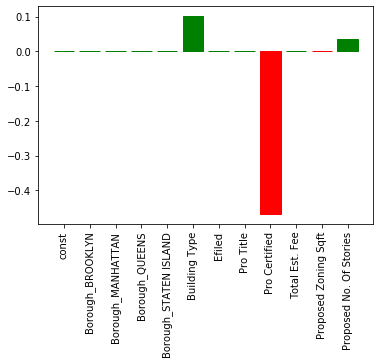

In [76]:
# Lasso regression selects only the most important features. In our case those are the 
# Building type, Pro Certified and Proposed No. of Stories. 

names = X.columns # create the names of the variables

fig, ax = plt.subplots()
ax.bar(range(len(names)),lasso.coef_) # plot the lasso regression coefficients
ax.set_xticks(range(len(names)));
ax.set_xticklabels(names, rotation=90)
for i, v in enumerate(lasso.coef_): # color coefficients red (negative) or green (positive)
    if v < 0:
        ax.get_children()[i].set_color('red')
    else:
        ax.get_children()[i].set_color('green')

* Lasso model is Helpful for feature selection. Identifies the most important variables.
* The most important variables are the building type (1-2-3 family or Other, professional certification and proposed number of stories). Namely, the duration 
    * increases if the building is type "other"
    * decreases if the application is professionally certified
    * increases if the number of stories is high

#### Ridge Regression

In [77]:
from sklearn import linear_model
from sklearn.linear_model import Ridge

In [156]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Instantiate the ridge regression and fit the train data

# Ridge regression with built-in cross-validation for alpha values
ridgecv = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))

ridgecv.fit(X_train, y_train)

alpha = reg.alpha_

# compute and print the R2: how much of the variance in the y is explained by the model.

ridge_R_cv = np.mean(cross_val_score(ridgecv, X_test, y_test, cv=5))

print("R squared for the ridge regression is {:.2f}".format(ridge_R_cv))

R squared for the ridge regression is 0.36


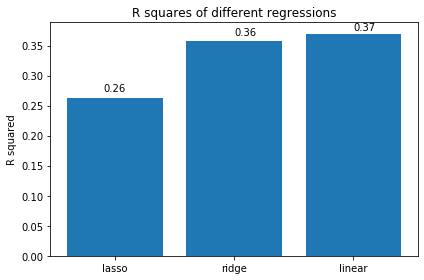

In [143]:
# Plot all regression R squares to see which one performs the best

r_squares = [cv_linreg,cv_lasso,ridge_R_cv]
plt.bar(range(len(r_squares)),np.sort(r_squares))
plt.xticks((0,1,2),('lasso','ridge','linear'))
plt.ylabel('R squared');
plt.title('R squares of different regressions');
plt.annotate(str(cv_lasso.round(2)), (-0.1,cv_lasso+0.01))
plt.annotate(str(ridge_R_cv.round(2)), (1,ridge_R_cv+0.01))
plt.annotate(str(cv_linreg.round(2)), (2,cv_linreg+0.005));
plt.tight_layout()

In [136]:
np.round(r_squares,2)

array([0.37, 0.26, 0.36])

In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler